# Homework 2: Unsupervised Deep Learning

##Using autoencoders for Deep Learning


##Select device

In [ ]:
#info about gpu
!nvidia-smi

Thu May  6 09:13:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |   1108MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
cpu_default = False

global device
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
device_cpu = torch.device("cpu")

if cpu_default: device=device_cpu
print('Selected device:',device)

Selected device: cuda


## Import Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,confusion_matrix
from tqdm.auto import tqdm
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms

!pip install optuna
import optuna
from optuna.trial import TrialState
import joblib

!pip install imageio
import imageio

##Work folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab Notebooks/Neural Networks and Deep Learning/Homework2'
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Neural Networks and Deep Learning/Homework2


#Autoencoder Network Class

##Encoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_channels=32, n_fcl=200):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, num_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(num_channels, num_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(num_channels, num_channels, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * num_channels, n_fcl),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(n_fcl, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

##Decoder

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_channels=32, n_fcl=200):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, n_fcl),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(n_fcl, 3 * 3 * num_channels),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(num_channels, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(num_channels, num_channels, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(num_channels, num_channels, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(num_channels, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

#Convolutional Autoencoder

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

## Data

In [ ]:
dataset = torchvision.datasets.MNIST('mnist_dataset', train=True, download=True)
train_dataset = dataset
test_dataset  = torchvision.datasets.MNIST('mnist_dataset', train=False, download=True)

### Examples

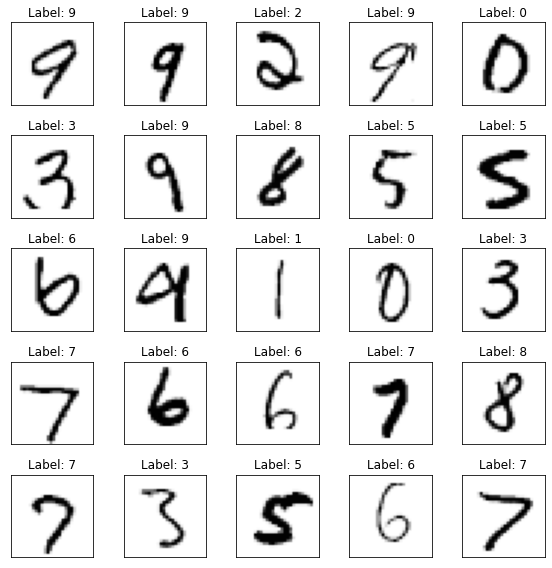

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='Greys')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

###Transformation

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Validation set division and dataloaders

In [ ]:
batch_size=50
train_dataset,val_dataset=torch.utils.data.random_split(dataset, [50000,10000])
train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Image for evolution during training with GIF

Image for evolution over training


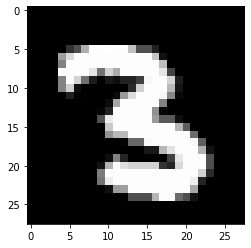

GIF Example


In [ ]:
test_img=val_dataset[0][0].unsqueeze(0).to(device)
print('Image for evolution over training')
fig = plt.figure(figsize=(4,4))
plt.imshow((test_img.view([28,28]).cpu().numpy()*255).astype(np.uint8),cmap='gray')
plt.show()

print('GIF Example')
test_images=[(val_dataset[i][0].squeeze().numpy()*255).astype(np.uint8) for i in range(10)]
imageio.mimwrite('example.gif', test_images, fps=5)

from IPython.display import Image
Image(open('example.gif','rb').read(),width=200,height=200)

## Optuna

### Training

In [ ]:
n_models=40
num_epochs_max = 100
loss_fn = nn.MSELoss()

def objective(trial):
  net_name=f'Autoencoder_{trial.number}'
  gif_images=[(test_img.view([28,28]).cpu().numpy()*255).astype(np.uint8)]

  #Parameters
  opt = trial.suggest_categorical("optimizer", ["SGDM", "Adam", "Adagrad"])
  lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
  weight_decay=trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
  n_fcl=trial.suggest_int("n_fcl", 100, 300)
  encoded_space_dim = trial.suggest_int("encoded_space_dim", 2, 6)
  
  print('----------------------------------')
  print(net_name)
  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
  print('----------------------------------')
    
  ### Initialize the two networks
  encoder = Encoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
  decoder = Decoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
  params_to_optimize = [{'params': encoder.parameters()},
                        {'params': decoder.parameters()}]
  # Define the optimizer
  optimizers={'SGDM':optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay, momentum=0.9),
              'Adam':optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay),
              'Adagrad':optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)}
  optimizer = optimizers[opt]

  ### TRAINING LOOP
  train_loss_log = []
  val_loss_log = []
  time_start = time.time()
  
  for epoch_num in range(num_epochs_max):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    encoder.train()
    decoder.train()
    for image_batch, _ in tqdm(train_dataloader):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    ### VALIDATION
    val_loss= []
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      #Track reconstruction hystory
      rec_img  = decoder(encoder(test_img))
      gif_images.append((rec_img.view([28,28]).cpu().numpy()*255).astype(np.uint8))

      for image_batch, _ in tqdm(val_dataloader):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average losses
    train_loss = np.mean(train_loss)      
    val_loss = np.mean(val_loss)
    print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
    print(f"\tAVERAGE VAL LOSS: {val_loss}")
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    trial.report(val_loss, epoch_num)
    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    #Early Stopping
    min_epochs=30
    window=10
    if epoch_num+1>=min_epochs and epoch_num+1>=window:
      print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
      if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
        print('Early Stopping')
        break

  time_end = time.time()
  time_training=time_end-time_start

  #Save data  
  path='optuna_models/'+net_name
  os.makedirs(path,exist_ok=True)
  pd.DataFrame(train_loss_log,columns=['train_loss']).to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
  pd.DataFrame(val_loss_log,columns=['valid_loss']).to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
  encoder_state_dict = encoder.state_dict()
  decoder_state_dict = decoder.state_dict()
  torch.save(encoder_state_dict, os.path.join(path,'encoder_params.torch'))
  torch.save(decoder_state_dict, os.path.join(path,'decoder_params.torch'))
  pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)
  os.makedirs('GIFs',exist_ok=True)
  imageio.mimwrite(os.path.join('GIFs',f'{net_name}.gif'), gif_images, fps=5)

  return val_loss


try:
  study = joblib.load("optuna_study.pkl")
  last_state=study.get_trials()[-1].state
  trials=study.get_trials()
  sampler=study.sampler
  pruner=study.pruner
  if last_state==TrialState.RUNNING or last_state==TrialState.FAIL or last_state==TrialState.WAITING:
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
    study.add_trials(trials[0:-1])
except: 
  sampler = optuna.samplers.TPESampler(seed=0) 
  study = optuna.create_study(direction="minimize", sampler=sampler)
  for opt in ["SGDM", "Adam", "Adagrad"]:
    for lr in [1e-4, 1e-3]:
      for weight_decay in [5e-5, 5e-4]:
        n_fcl=200
        encoded_space_dim = 2
        study.enqueue_trial({"optimizer": opt, 'lr': lr, "weight_decay":weight_decay, "n_fcl":n_fcl, "encoded_space_dim":encoded_space_dim})

finished=len(study.get_trials(deepcopy=True, states=[TrialState.COMPLETE]))
for i in range(n_models-finished):
  study.optimize(objective, n_trials=1)
  joblib.dump(study, "optuna_study.pkl")

###Optuna study results

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = sorted(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]),key=lambda x: x.value)
best_10_trials=complete_trials[:10]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

log_dataset={}
best_10_nets=[]

print("Best 10 trials:")
for trial in best_10_trials:
  net_name=f'Autoencoder_{trial.number}'
  path='optuna_models/'+net_name

  encoder = Encoder(encoded_space_dim=trial.params['encoded_space_dim'],n_fcl=trial.params['n_fcl']).to(device)
  decoder = Decoder(encoded_space_dim=trial.params['encoded_space_dim'],n_fcl=trial.params['n_fcl']).to(device)

  # Load the network parameters and data
  time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
  encoder_state_dict=torch.load(os.path.join(path,'encoder_params.torch'),map_location=torch.device(dev))
  decoder_state_dict=torch.load(os.path.join(path,'decoder_params.torch'),map_location=torch.device(dev))
  encoder.load_state_dict(encoder_state_dict)
  decoder.load_state_dict(decoder_state_dict)
  try:
    log_dataset[net_name]
  except:
    log_dataset[net_name]=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset[net_name]['train_loss']=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset[net_name]['valid_loss']=pd.read_csv(os.path.join(path,'net_valid_loss.csv'))
  
  print('----------------------------------')
  print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
  print("  Value: ", trial.value)
  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
  print('----------------------------------')
  
  best_10_nets.append((net_name,copy.deepcopy(encoder),copy.deepcopy(decoder)))

Study statistics: 
  Number of finished trials:  80
  Number of pruned trials:  40
  Number of complete trials:  40
Best 10 trials:
----------------------------------
Autoencoder_77 -- training time: 17.0 min 4.84 sec
  Value:  0.018459387123584747
  Params: 
    optimizer: Adam
    lr: 0.00036969055147174066
    weight_decay: 1.2875449951900318e-05
    n_fcl: 103
    encoded_space_dim: 6
----------------------------------
----------------------------------
Autoencoder_62 -- training time: 13.0 min 32.33 sec
  Value:  0.018566995859146118
  Params: 
    optimizer: Adam
    lr: 0.0005500715878668001
    weight_decay: 1.1151277563057527e-05
    n_fcl: 130
    encoded_space_dim: 6
----------------------------------
----------------------------------
Autoencoder_56 -- training time: 12.0 min 3.87 sec
  Value:  0.018727006390690804
  Params: 
    optimizer: Adam
    lr: 0.0009494874203753733
    weight_decay: 1.2993995817382712e-05
    n_fcl: 137
    encoded_space_dim: 6
-------------------

### Validation error history

In [ ]:
optuna.visualization.plot_intermediate_values(study)

### Optimization history

In [ ]:
optuna.visualization.plot_optimization_history(study)

### Hyperparameters importances

In [ ]:
optuna.visualization.plot_param_importances(study)

### Hyperparameters values overview

In [ ]:
optuna.visualization.plot_slice(study)

### Best 10 models error history

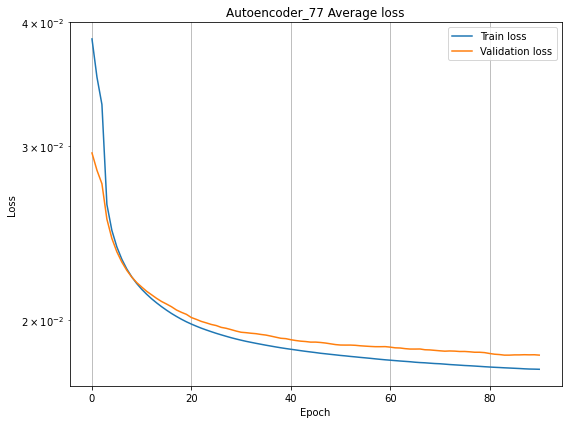

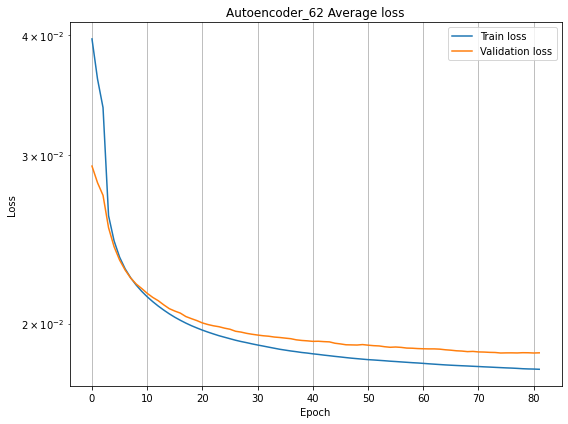

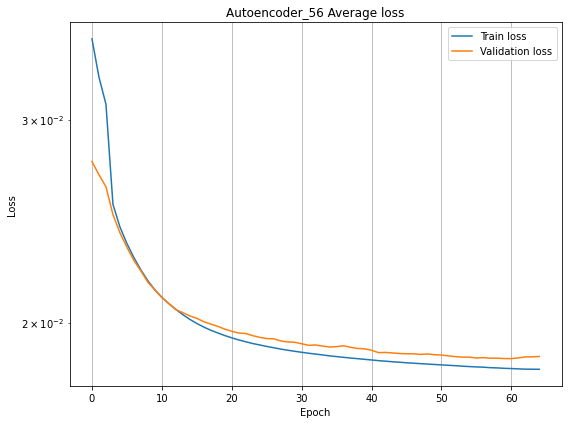

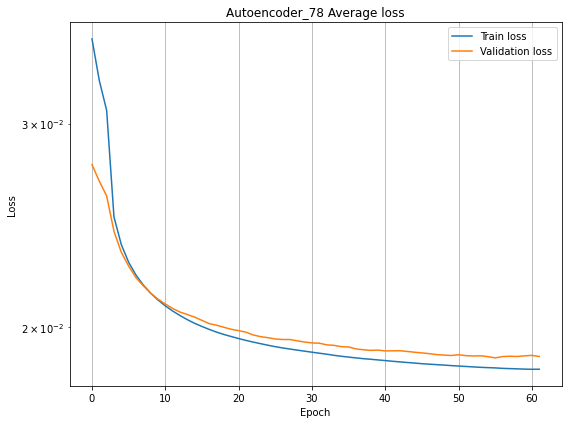

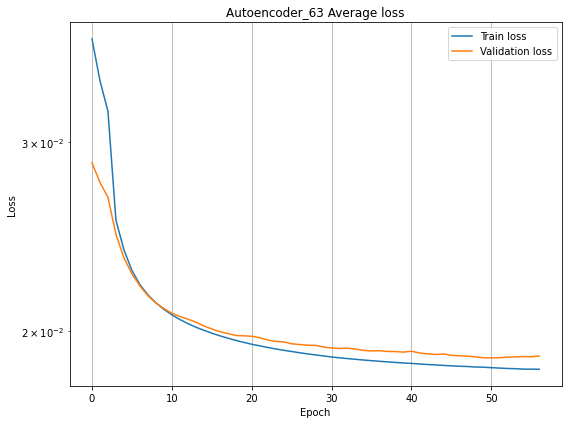

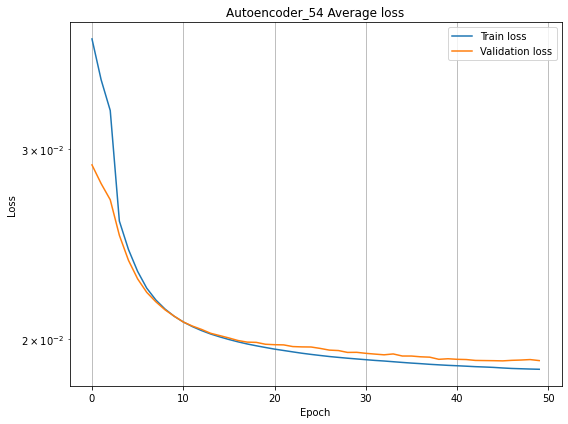

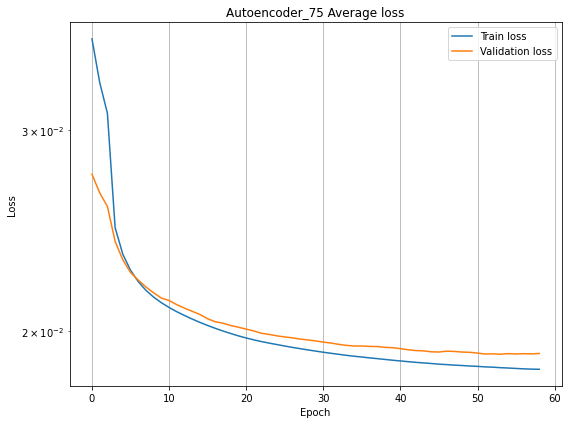

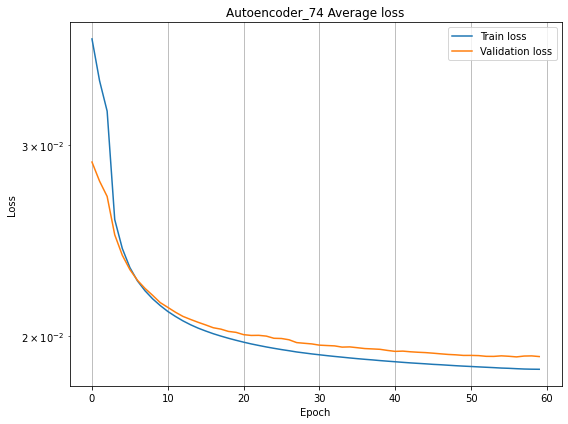

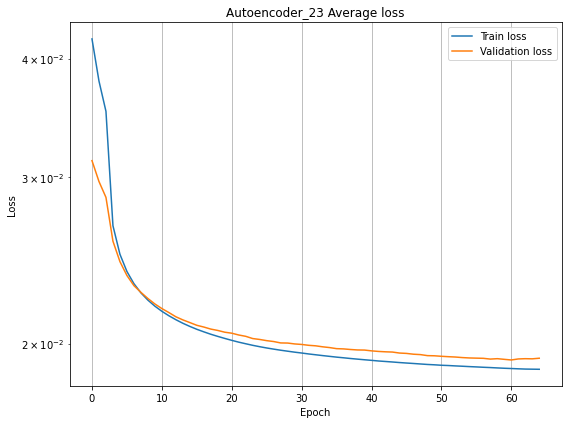

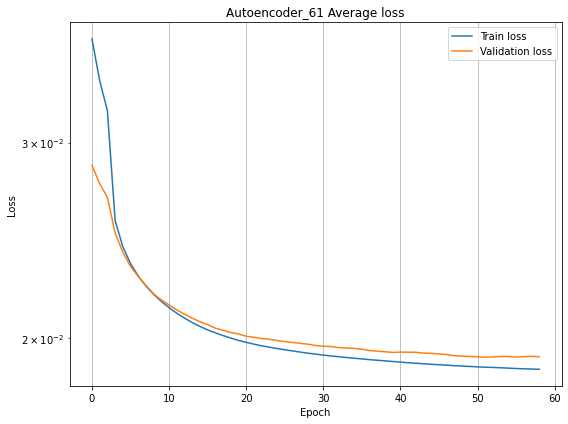

In [ ]:
model_performances=[]
for trial in best_10_trials:
  net_name=f'Autoencoder_{trial.number}'
  smoothing_window=5       
  smoothed_train_loss=log_dataset[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
  smoothed_valid_loss=log_dataset[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
  plt.figure(figsize=(8,6))
  plt.title(net_name+' Average loss')
  plt.semilogy(smoothed_train_loss, label='Train loss')
  plt.semilogy(smoothed_valid_loss, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

  model_performances.append([net_name,smoothed_train_loss.min(),smoothed_valid_loss.min()])


## Validate best optuna models with cross validation

###Training

In [ ]:
n_models_evaluated=5
log_dataset_CV={}

for trial in best_10_trials[:n_models_evaluated]:
  net_name=f'Autoencoder_{trial.number}'

  #Parameters
  opt = trial.params["optimizer"]
  lr = trial.params['lr']
  weight_decay = trial.params["weight_decay"]
  n_fcl = trial.params["n_fcl"]
  encoded_space_dim = trial.params["encoded_space_dim"]
  num_epochs_max = len(log_dataset[net_name]['valid_loss'])
  
  print('----------------------------------')
  print(net_name)
  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
  print('----------------------------------')
  path='optuna_best_models_CV/'+net_name
  os.makedirs(path,exist_ok=True)

  #Cross Validation
  k=3
  for i,(train_index,valid_index) in enumerate(KFold(n_splits=k).split(dataset)):
    train_dataloader= DataLoader(Subset(dataset,train_index), batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader  = DataLoader(Subset(dataset,valid_index), batch_size=batch_size, shuffle=False, num_workers=0) 
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
    params_to_optimize = [{'params': encoder.parameters()},
                          {'params': decoder.parameters()}]
    # Define the optimizer
    optimizers={'SGDM':optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay, momentum=0.9),
                'Adam':optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay),
                'Adagrad':optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)}
    optimizer = optimizers[opt] 

    # Load the network parameters and data
    time_training=0
    try:
      time_training=pd.read_csv(os.path.join(path,f'time_training{i}.csv')).iloc[0,0]
      encoder_state_dict=torch.load(os.path.join(path,f'encoder_params{i}.torch'),map_location=torch.device(dev))
      decoder_state_dict=torch.load(os.path.join(path,f'decoder_params{i}.torch'),map_location=torch.device(dev))
      encoder.load_state_dict(encoder_state_dict)
      decoder.load_state_dict(decoder_state_dict)
      try:
        log_dataset_CV[net_name]
      except:
        log_dataset_CV[net_name]=pd.read_csv(os.path.join(path,f'net_train_loss{i}.csv'))
      log_dataset_CV[net_name][f'train_loss{i}']=pd.read_csv(os.path.join(path,f'net_train_loss{i}.csv'))
      log_dataset_CV[net_name][f'valid_loss{i}']=pd.read_csv(os.path.join(path,f'net_valid_loss{i}.csv'))
      train=False
    except:
      train=True
    
    print()
    print(f'{i}-th Validation model --- training time: {time_training//60} min {round(time_training%60,2)} sec')
    print()

    ### TRAINING LOOP
    train_loss_log = []
    val_loss_log = []
    time_start = time.time()
    
    if train:
      for epoch_num in range(num_epochs_max):
        print(f'EPOCH {epoch_num}')

        ### TRAIN
        train_loss= []
        encoder.train()
        decoder.train()
        for image_batch, _ in tqdm(train_dataloader):
          # Move tensor to the proper device
          image_batch = image_batch.to(device)
          # Encode data
          encoded_data = encoder(image_batch)
          # Decode data
          decoded_data = decoder(encoded_data)
          # Evaluate loss
          loss = loss_fn(decoded_data, image_batch)
          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Save train loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          train_loss.append(loss_batch)

        ### VALIDATION
        val_loss= []
        encoder.eval()
        decoder.eval()
        with torch.no_grad(): # Disable gradient tracking
          for image_batch, _ in tqdm(val_dataloader):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Evaluate loss
            loss = loss_fn(decoded_data, image_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average losses
        train_loss = np.mean(train_loss)      
        val_loss = np.mean(val_loss)
        print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
        print(f"\tAVERAGE VAL LOSS: {val_loss}")
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)

      time_end = time.time()
      time_training=time_end-time_start

      #Save data
      pd.DataFrame(train_loss_log,columns=[f'train_loss{i}']).to_csv(os.path.join(path,f'net_train_loss{i}.csv'),index=False)
      pd.DataFrame(val_loss_log,columns=[f'valid_loss{i}']).to_csv(os.path.join(path,f'net_valid_loss{i}.csv'),index=False)
      encoder_state_dict = encoder.state_dict()
      decoder_state_dict = decoder.state_dict()
      torch.save(encoder_state_dict, os.path.join(path,f'encoder_params{i}.torch'))
      torch.save(decoder_state_dict, os.path.join(path,f'decoder_params{i}.torch'))
      pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,f'time_training{i}.csv'),index=False)

----------------------------------
Autoencoder_77
  Params: 
    optimizer: Adam
    lr: 0.00036969055147174066
    weight_decay: 1.2875449951900318e-05
    n_fcl: 103
    encoded_space_dim: 6
----------------------------------

0-th Validation model --- training time: 13.0 min 19.62 sec


1-th Validation model --- training time: 14.0 min 11.45 sec


2-th Validation model --- training time: 15.0 min 22.04 sec

----------------------------------
Autoencoder_62
  Params: 
    optimizer: Adam
    lr: 0.0005500715878668001
    weight_decay: 1.1151277563057527e-05
    n_fcl: 130
    encoded_space_dim: 6
----------------------------------

0-th Validation model --- training time: 14.0 min 16.28 sec


1-th Validation model --- training time: 15.0 min 2.42 sec


2-th Validation model --- training time: 15.0 min 49.35 sec

----------------------------------
Autoencoder_56
  Params: 
    optimizer: Adam
    lr: 0.0009494874203753733
    weight_decay: 1.2993995817382712e-05
    n_fcl: 137
    enc

###Error history

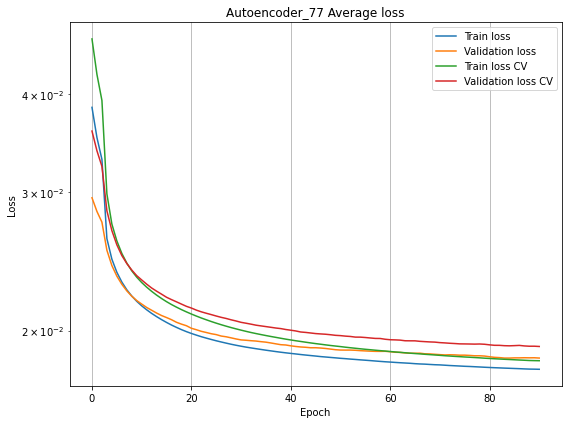

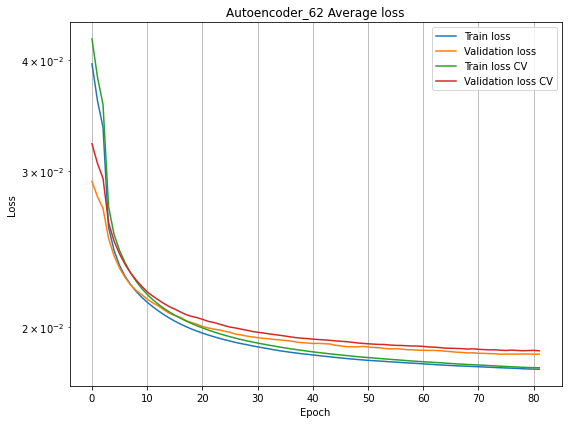

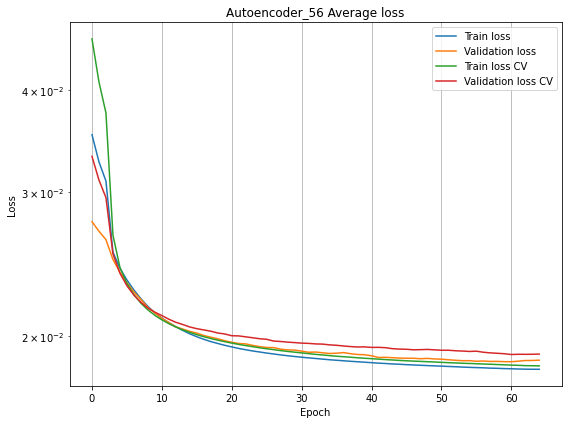

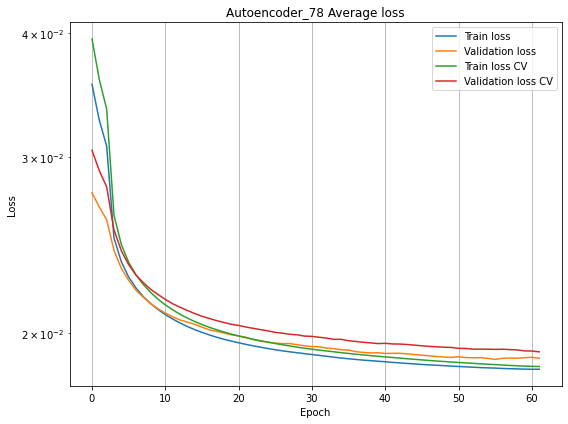

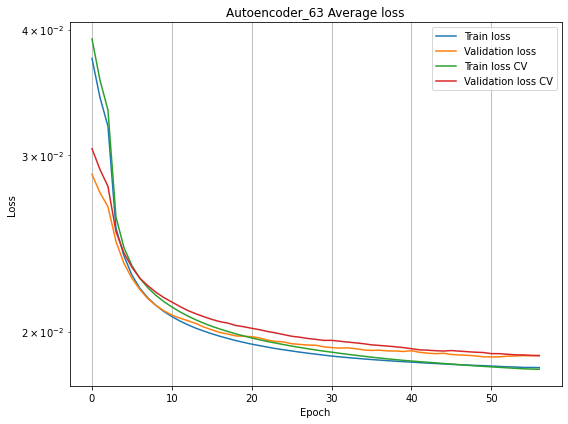

In [ ]:
loss_comparison=[]
for trial in complete_trials[:n_models_evaluated]:
  net_name=f'Autoencoder_{trial.number}'
  smoothed_train_loss=log_dataset[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
  smoothed_valid_loss=log_dataset[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
  average_train_loss=log_dataset_CV[net_name].iloc[:,0::2].mean(axis=1)
  average_valid_loss=log_dataset_CV[net_name].iloc[:,1::2].mean(axis=1)
  smoothing_window=5        
  smoothed_train_loss_CV=average_train_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
  smoothed_valid_loss_CV=average_valid_loss.rolling(smoothing_window, min_periods=1,center=True).mean()
  plt.figure(figsize=(8,6))
  plt.title(net_name+' Average loss')
  plt.semilogy(smoothed_train_loss, label='Train loss')
  plt.semilogy(smoothed_valid_loss, label='Validation loss')
  plt.semilogy(smoothed_train_loss_CV, label='Train loss CV')
  plt.semilogy(smoothed_valid_loss_CV, label='Validation loss CV')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()
  loss_comparison.append((net_name,smoothed_train_loss.min(),smoothed_train_loss_CV.min(),smoothed_valid_loss.min(),smoothed_valid_loss_CV.min()))

###Loss comparison

In [ ]:
loss_comparison=pd.DataFrame(loss_comparison,columns=['Net name', 'Min Train Loss', 'Min Train Loss CV', 'Min Valid Loss', 'Min Valid Loss CV'])
loss_comparison['Valid loss % difference']=((loss_comparison['Min Valid Loss']-loss_comparison['Min Valid Loss CV']).abs())/loss_comparison['Min Valid Loss CV']*100
display(loss_comparison)

Net name  Min Train Loss  ...  Min Valid Loss CV  Valid loss % difference
0  Autoencoder_77        0.017852  ...           0.019087                 3.343429
1  Autoencoder_62        0.017924  ...           0.018807                 0.895270
2  Autoencoder_56        0.018223  ...           0.018996                 2.005484
3  Autoencoder_78        0.018387  ...           0.019144                 1.740350
4  Autoencoder_63        0.018419  ...           0.018924                 0.255381

[5 rows x 6 columns]

##Test performances 

In [ ]:
for i,(net_name,encoder,decoder) in enumerate(best_10_nets): 
  test_loss= [] 
  encoder.eval()
  decoder.eval()
  with torch.no_grad(): # Disable gradient tracking
    for image_batch, _ in tqdm(test_dataloader):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      test_loss.append(loss_batch)     
  test_loss = np.mean(test_loss)
  model_performances[i].append(test_loss)

In [ ]:
model_results=pd.DataFrame(model_performances,columns=['Model Name','Min Train Loss','Min Valid Loss','Test Loss'])
display(model_results)

Model Name  Min Train Loss  Min Valid Loss  Test Loss
0  Autoencoder_77        0.017852        0.018449   0.018257
1  Autoencoder_62        0.017924        0.018639   0.018346
2  Autoencoder_56        0.018223        0.018615   0.018672
3  Autoencoder_78        0.018387        0.018810   0.018640
4  Autoencoder_63        0.018419        0.018875   0.018682
5  Autoencoder_54        0.018758        0.019098   0.018913
6  Autoencoder_75        0.018518        0.019090   0.018926
7  Autoencoder_74        0.018639        0.019136   0.018939
8  Autoencoder_23        0.018791        0.019221   0.019048
9  Autoencoder_61        0.018756        0.019231   0.019074

## Save best model

In [ ]:
path='best_model'
os.makedirs(path,exist_ok=True)
net_name,encoder,decoder = best_10_nets[0]
log_dataset[net_name]['train_loss'].to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
log_dataset[net_name]['valid_loss'].to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
encoder_state_dict = encoder.state_dict()
decoder_state_dict = decoder.state_dict()
torch.save(encoder_state_dict, os.path.join(path,'encoder_params.torch'))
torch.save(decoder_state_dict, os.path.join(path,'decoder_params.torch'))
pd.DataFrame(study.best_trial.params, index=[0]).to_csv(os.path.join(path,'train_params.csv'),index=False)
torch.save(encoder, os.path.join(path,'best_encoder.pth'))
torch.save(decoder, os.path.join(path,'best_decoder.pth'))

##Best model evolution gif and reconstructed samples

In [ ]:
net_name,encoder,decoder = best_10_nets[0]
Image(open(os.path.join('GIFs',f'{net_name}.gif'),'rb').read(),width=200,height=200)

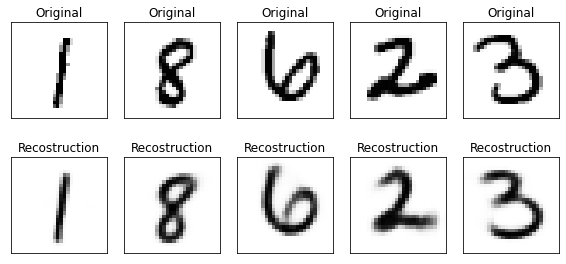

In [ ]:
encoder.eval()
decoder.eval()
fig, axs = plt.subplots(2, 5, figsize=(8,4))
axs=axs.flatten()
for i in range(len(axs)//2):
    shift=len(axs)//2
    img= random.choice(test_dataset)[0].view([28,28])
    rec_img=decoder(encoder(img.view([1,1,28,28]).to(device))).view([28,28])
    axs[i].imshow(np.array(img), cmap='Greys')
    axs[i].set_title('Original')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+shift].imshow(rec_img.cpu().detach().numpy(), cmap='Greys')
    axs[i+shift].set_title('Recostruction')
    axs[i+shift].set_xticks([])
    axs[i+shift].set_yticks([])
plt.tight_layout()
plt.show()

##Explore latent space and generate samples

### Encoded Space

In [ ]:
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    labels.append(label)
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
display(encoded_samples)

Enc. Variable 0  Enc. Variable 1  ...  Enc. Variable 4  Enc. Variable 5
0           31.984169         7.403225  ...        11.668688        -2.791056
1          -18.834812        26.578333  ...        10.530387        25.891922
2            0.494231        22.757612  ...       -11.629248       -10.954997
3          -14.241377       -15.594882  ...        -7.239049        23.790581
4           21.961691        -3.529304  ...       -13.618458         6.632059
...               ...              ...  ...              ...              ...
9995         3.692021        36.180023  ...        26.234827        27.119656
9996       -19.128517         1.136918  ...        -0.646961        24.383131
9997        38.403870        17.108212  ...       -10.332069       -10.995756
9998        -0.389446       -18.280966  ...        -8.910711       -31.009995
9999       -32.045532       -17.123907  ...       -33.846355         7.042679

[10000 rows x 6 columns]

###PCA

In [ ]:
from sklearn.decomposition import PCA
n_components=2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples)
columns = [f'pca{i}' for i in range(n_components)]
encoded_samples_pca = pd.DataFrame(pca.transform(encoded_samples), columns=['pca1', 'pca2'])
display(encoded_samples_pca)

pca1       pca2
0     32.433041  -9.776738
1    -14.980726 -28.650308
2     12.203384  -4.961845
3    -37.657747  19.441377
4     11.877467  29.901540
...         ...        ...
9995  -1.658469 -21.218561
9996 -26.964879 -34.013053
9997  35.169733  20.229979
9998  -2.932084   2.176241
9999 -39.572858  30.537237

[10000 rows x 2 columns]

In [ ]:
encoded_samples_pca['label']=labels
import plotly.express as px
px.scatter(encoded_samples_pca, x='pca1', y='pca2', color=encoded_samples_pca.label.astype(str), opacity=0.7)

###t-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0)
encoded_samples_tsne = tsne.fit_transform(encoded_samples)

encoded_samples_tsne=pd.DataFrame(encoded_samples_tsne, columns=['tsne1', 'tsne2'])
display(encoded_samples_tsne)

tsne1      tsne2
0     13.139144 -66.060837
1     30.470095  42.131989
2    -48.135418  35.782532
3     69.815697  -2.149482
4    -68.070427 -24.149883
...         ...        ...
9995  39.529137  45.543671
9996  12.227431  19.785990
9997 -54.164822 -17.398520
9998 -37.975307   4.136648
9999  -9.394447  71.580544

[10000 rows x 2 columns]

In [ ]:
encoded_samples_tsne['label']=labels
import plotly.express as px
px.scatter(encoded_samples_tsne, x='tsne1', y='tsne2', color=encoded_samples_pca.label.astype(str), opacity=0.7)

### Sample from encoded space

Enc. Variable 0    28.336331
Enc. Variable 1     1.519525
Enc. Variable 2    -4.319949
Enc. Variable 3   -13.529023
Enc. Variable 4   -13.910025
Enc. Variable 5    -0.169529
dtype: float64

Sampled image, class 9


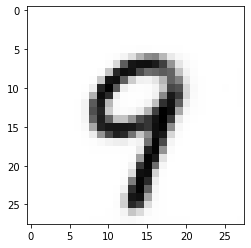

Enc. Variable 0     0.505900
Enc. Variable 1     2.045137
Enc. Variable 2     9.832751
Enc. Variable 3   -23.877063
Enc. Variable 4     1.326569
Enc. Variable 5    14.995889
dtype: float64

Mixed sampled image, class 3 and 8


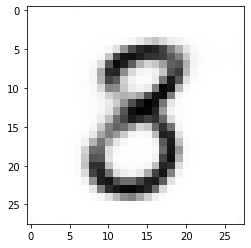

In [ ]:
encoded_samples['label']=labels
class_sample=9
n_samples_for_mean=20
selected_samples=encoded_samples[encoded_samples['label']==class_sample]

selected_sample=selected_samples.sample(n_samples_for_mean).mean(axis=0)[:-1]
display(selected_sample)
selected_sample=torch.Tensor(selected_sample).unsqueeze(0).to(device)
rec_img=decoder(selected_sample)
print(f'Sampled image, class {class_sample}')
fig = plt.figure(figsize=(4,4))
plt.imshow(rec_img.view([28,28]).cpu().detach(),cmap='Greys')
plt.show()

#Mixed Sample
class_sample0=3
class_sample1=8
n_samples_for_mean=40
selected_samples=encoded_samples[encoded_samples['label']==class_sample0]
selected_samples=selected_samples.append(encoded_samples[encoded_samples['label']==class_sample1])

selected_sample=selected_samples.sample(n_samples_for_mean).mean(axis=0)[:-1]
display(selected_sample)
selected_sample=torch.Tensor(selected_sample).unsqueeze(0).to(device)
rec_img=decoder(selected_sample)
print(f'Mixed sampled image, class {class_sample0} and {class_sample1}')
fig = plt.figure(figsize=(4,4))
plt.imshow(rec_img.view([28,28]).cpu().detach(),cmap='Greys')
plt.show()

## Exploit encoder for classification

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

path='best_model'
class_encoder=torch.load(os.path.join(path,'best_encoder.pth'))
train_params=pd.read_csv(os.path.join(path,'train_params.csv'))
print(class_encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=103, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=103, out_features=6, bias=True)
  )
)


###Data

In [ ]:
dataset = torchvision.datasets.MNIST('mnist_dataset', train=True, download=True)
train_dataset = dataset
test_dataset  = torchvision.datasets.MNIST('mnist_dataset', train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset.transform = train_transform
test_dataset.transform = test_transform
batch_size=50
train_dataset,val_dataset=torch.utils.data.random_split(dataset, [50000,10000])
train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Freeze convolutional part

In [ ]:
for param in class_encoder.encoder_cnn.parameters():
  param.requires_grad = False

### Change last layer

In [ ]:
num_classes = 10
class_encoder.encoder_lin[2] = torch.nn.Linear(103, num_classes)
print(class_encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=103, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=103, out_features=10, bias=True)
  )
)


### Check parameters status

In [ ]:
for param_name, param in class_encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

encoder_cnn.0.weight 	- requires_grad=False
encoder_cnn.0.bias 	- requires_grad=False
encoder_cnn.2.weight 	- requires_grad=False
encoder_cnn.2.bias 	- requires_grad=False
encoder_cnn.4.weight 	- requires_grad=False
encoder_cnn.4.bias 	- requires_grad=False
encoder_lin.0.weight 	- requires_grad=True
encoder_lin.0.bias 	- requires_grad=True
encoder_lin.2.weight 	- requires_grad=True
encoder_lin.2.bias 	- requires_grad=True


###Training

In [ ]:
#Parameters
loss_fn = nn.CrossEntropyLoss()
num_epochs_max = 30
opt=train_params['optimizer'][0]
lr=train_params['lr'][0]
weight_decay=train_params['weight_decay'][0]

log_dataset_class={}

# Initialize the network
net = copy.deepcopy(class_encoder)
net.to(device)
# Define the optimizer
optimizers={'SGDM':optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9),
            'Adam':optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay),
            'Adagrad':optim.Adagrad(net.parameters(), lr=lr, weight_decay=weight_decay)}
optimizer = optimizers[opt]

net_name=f'Classification_Encoder'

path=net_name
os.makedirs(path,exist_ok=True)

# Load the network parameters and data
time_training=0
try:
  time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
  net_state_dict=torch.load(os.path.join(path,'net_params.torch'),map_location=torch.device(dev))
  net.load_state_dict(net_state_dict)
  try:
    log_dataset_class[net_name]
  except:
    log_dataset_class[net_name]=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_class[net_name]['train_loss']=pd.read_csv(os.path.join(path,f'net_train_loss.csv'))
  log_dataset_class[net_name]['valid_loss']=pd.read_csv(os.path.join(path,f'net_valid_loss.csv'))
  train=False
except:
  train=True

print('----------------------------------')
print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
print('----------------------------------')

### TRAINING LOOP
train_loss_log = []
val_loss_log = []
time_start = time.time()

if train:
  for epoch_num in range(num_epochs_max):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in tqdm(train_dataloader):
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in tqdm(val_dataloader):
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average losses
      train_loss = np.mean(train_loss)      
      val_loss = np.mean(val_loss)
      print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
      print(f"\tAVERAGE VAL LOSS: {val_loss}")
      train_loss_log.append(train_loss)
      val_loss_log.append(val_loss)

      #Early Stopping
      min_epochs=10
      window=10
      if epoch_num+1>=min_epochs and epoch_num+1>=window:
        print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
        if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
          print('Early Stopping')
          break

  time_end = time.time()
  time_training=time_end-time_start

  #Save data
  try:
    log_dataset_class[net_name]
  except:
    log_dataset_class[net_name]=pd.DataFrame()
  log_dataset_class[net_name]['train_loss']=train_loss_log
  log_dataset_class[net_name]['valid_loss']=val_loss_log
  log_dataset_class[net_name]['train_loss'].to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
  log_dataset_class[net_name]['valid_loss'].to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
  net_state_dict = net.state_dict()
  torch.save(net_state_dict, os.path.join(path,'net_params.torch'))
  pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)

----------------------------------
Classification_Encoder -- training time: 1.0 min 42.72 sec
----------------------------------


### Error history

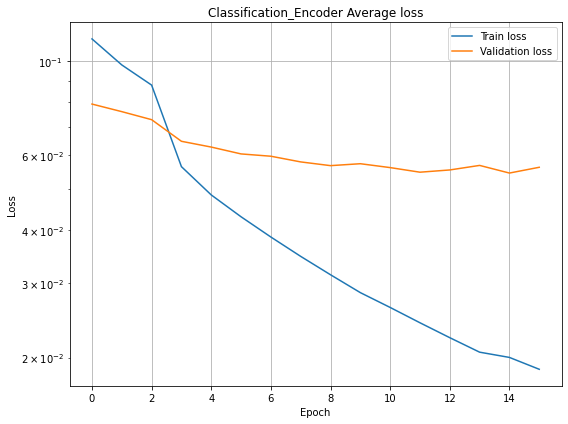

In [ ]:
smoothing_window=5       
smoothed_train_loss=log_dataset_class[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
smoothed_valid_loss=log_dataset_class[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
plt.figure(figsize=(8,6))
plt.title(net_name+' Average loss')
plt.semilogy(smoothed_train_loss, label='Train loss')
plt.semilogy(smoothed_valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

###Test performances

In [ ]:
x_test=test_dataset.data.unsqueeze(1).float().to(device)
y_test=test_dataset.targets
net.eval()
with torch.no_grad():
    output = net(x_test)
softmax = nn.Softmax(dim=1)(output)
predictions = torch.argmax(softmax, dim=1).cpu()
accuracy=accuracy_score(y_test, predictions)
print(net_name)
print(f"Test Accuracy:{accuracy}")
print()

Classification_Encoder
Test Accuracy:0.9756



###Confusion Matrix

[[ 974    1    0    0    1    1    2    1    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   0   11 1008    3    1    1    2    6    0    0]
 [   0    0    0  997    0    6    0    5    1    1]
 [   0    5    0    0  967    0    5    0    0    5]
 [   0    1    0    3    0  882    4    1    1    0]
 [   3    3    0    0   12    3  937    0    0    0]
 [   0    7    6    2    0    0    0 1012    0    1]
 [   2   37    5   21    2   10    4    6  884    3]
 [   0   12    3    9    7    6    0   11    0  961]]


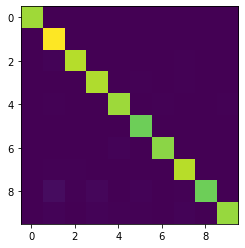

In [ ]:
c_matrix=confusion_matrix(y_test,predictions)
print(c_matrix)
plt.imshow(c_matrix)
plt.show()

#Denoising Autoencoder

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

###Data (adding Gaussian noise)

In [ ]:
dataset = torchvision.datasets.MNIST('mnist_dataset', train=True, download=True)
train_dataset = dataset
test_dataset  = torchvision.datasets.MNIST('mnist_dataset', train=False, download=True)

noise_factor=0.1
train_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Lambda(lambda x : (torch.clip(x + noise_factor*torch.randn_like(x), 0, 1), x))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Lambda(lambda x : (torch.clip(x + noise_factor*torch.randn_like(x), 0, 1), x))
])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

batch_size=50
train_dataset,val_dataset=torch.utils.data.random_split(dataset, [50000,10000])
train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Image example

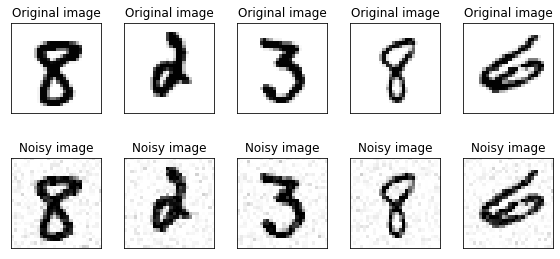

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(8,4))
axs=axs.flatten()
for i in range(len(axs)//2):
    shift=len(axs)//2
    sample = random.choice(train_dataset)
    noise_img = sample[0][0].view([28,28])
    img = sample[0][1].view([28,28])
    axs[i].imshow(img.cpu().detach(),cmap='Greys')
    axs[i].set_title('Original image')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+shift].imshow(noise_img.cpu().detach(), cmap='Greys')
    axs[i+shift].set_title('Noisy image')
    axs[i+shift].set_xticks([])
    axs[i+shift].set_yticks([])
plt.tight_layout()
plt.show()

##Training

In [ ]:
path='best_model'
train_params=pd.read_csv(os.path.join(path,'train_params.csv'))

#Parameters
loss_fn = nn.MSELoss()
num_epochs_max = 100
opt=train_params['optimizer'][0]
lr=train_params['lr'][0]
weight_decay=train_params['weight_decay'][0]
n_fcl = train_params["n_fcl"][0]
encoded_space_dim = train_params["encoded_space_dim"][0]

log_dataset_denoise={}

### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
decoder = Decoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
params_to_optimize = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]
# Define the optimizer
optimizers={'SGDM':optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay, momentum=0.9),
            'Adam':optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay),
            'Adagrad':optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)}
optimizer = optimizers[opt] 

net_name=f'Denoising_Autoencoder'

path=net_name
os.makedirs(path,exist_ok=True)

# Load the network parameters and data
time_training=0
try:
  time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
  encoder_state_dict=torch.load(os.path.join(path,'encoder_params.torch'),map_location=torch.device(dev))
  decoder_state_dict=torch.load(os.path.join(path,'decoder_params.torch'),map_location=torch.device(dev))
  encoder.load_state_dict(encoder_state_dict)
  decoder.load_state_dict(decoder_state_dict)
  try:
    log_dataset_denoise[net_name]
  except:
    log_dataset_denoise[net_name]=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_denoise[net_name]['train_loss']=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_denoise[net_name]['valid_loss']=pd.read_csv(os.path.join(path,'net_valid_loss.csv'))
  train=False
except:
  train=True

print('----------------------------------')
print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
print('----------------------------------')

### TRAINING LOOP
train_loss_log = []
val_loss_log = []
time_start = time.time()

if train:
  for epoch_num in range(num_epochs_max):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    encoder.train()
    decoder.train()
    for (noise_image_batch,image_batch), _ in tqdm(train_dataloader):
      # Move tensor to the proper device
      noise_image_batch = noise_image_batch.to(device)
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder(noise_image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    ### VALIDATION
    val_loss= []
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      for (noise_image_batch,image_batch), _ in tqdm(val_dataloader):
        # Move tensor to the proper device
        noise_image_batch = noise_image_batch.to(device)
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(noise_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average losses
    train_loss = np.mean(train_loss)      
    val_loss = np.mean(val_loss)
    print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
    print(f"\tAVERAGE VAL LOSS: {val_loss}")
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    #Early Stopping
    min_epochs=30
    window=10
    if epoch_num+1>=min_epochs and epoch_num+1>=window:
      print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
      if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
        print('Early Stopping')
        break

  time_end = time.time()
  time_training=time_end-time_start

  #Save data
  pd.DataFrame(train_loss_log,columns=['train_loss']).to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
  pd.DataFrame(val_loss_log,columns=['valid_loss']).to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
  try:
    log_dataset_denoise[net_name]
  except:
    log_dataset_denoise[net_name]=pd.DataFrame()  
  log_dataset_denoise[net_name]['train_loss']=train_loss_log
  log_dataset_denoise[net_name]['valid_loss']=val_loss_log
  encoder_state_dict = encoder.state_dict()
  decoder_state_dict = decoder.state_dict()
  torch.save(encoder_state_dict, os.path.join(path,'encoder_params.torch'))
  torch.save(decoder_state_dict, os.path.join(path,'decoder_params.torch'))
  pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)

----------------------------------
Denoising_Autoencoder -- training time: 15.0 min 44.29 sec
----------------------------------


##Error history

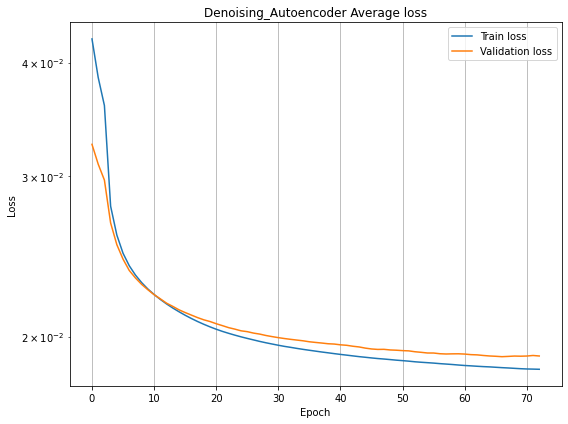

In [ ]:
smoothing_window=5       
smoothed_train_loss=log_dataset_denoise[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
smoothed_valid_loss=log_dataset_denoise[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
plt.figure(figsize=(8,6))
plt.title(net_name+' Average loss')
plt.semilogy(smoothed_train_loss, label='Train loss')
plt.semilogy(smoothed_valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

##Test performances

In [ ]:
test_loss= [] 
encoder.eval()
decoder.eval()
with torch.no_grad(): # Disable gradient tracking
  for (noise_image_batch,image_batch), _  in tqdm(test_dataloader):
    # Move tensor to the proper device
    noise_image_batch = noise_image_batch.to(device)
    image_batch = image_batch.to(device)
    # Encode data
    encoded_data = encoder(noise_image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss
    loss = loss_fn(decoded_data, image_batch)

    # Save val loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    test_loss.append(loss_batch)     
test_loss = np.mean(test_loss)
print(net_name)
print(f"Test Loss(MSE):{test_loss}")
print()


Denoising_Autoencoder
Test Loss(MSE):0.01883770152926445



##Reconstructed samples

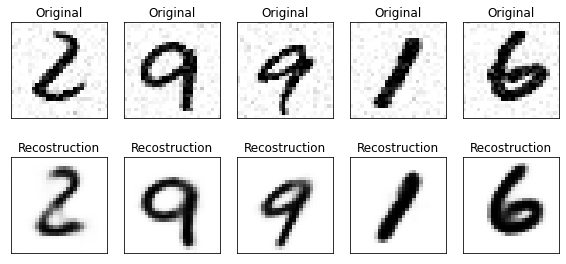

In [ ]:
encoder.eval()
decoder.eval()
fig, axs = plt.subplots(2, 5, figsize=(8,4))
axs=axs.flatten()
for i in range(len(axs)//2):
    shift=len(axs)//2
    noise_img = random.choice(test_dataset)[0][0].view([28,28])
    rec_img=decoder(encoder(noise_img.view([1,1,28,28]).to(device))).view([28,28])
    axs[i].imshow(np.array(noise_img), cmap='Greys')
    axs[i].set_title('Original')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+shift].imshow(rec_img.cpu().detach().numpy(), cmap='Greys')
    axs[i+shift].set_title('Recostruction')
    axs[i+shift].set_xticks([])
    axs[i+shift].set_yticks([])
plt.tight_layout()
plt.show()

##Test on samples with more noise

Test with 0.2 noise factor (0.1 original)



Denoising_Autoencoder
Test Loss(MSE):0.020124927163124084



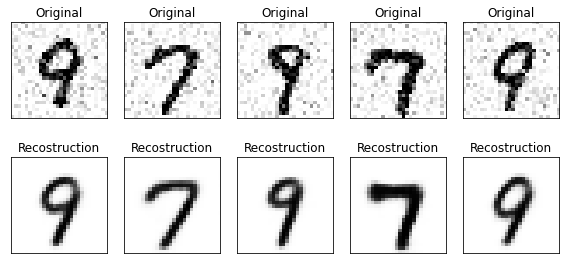

Test with 0.30000000000000004 noise factor (0.1 original)



Denoising_Autoencoder
Test Loss(MSE):0.026096906512975693



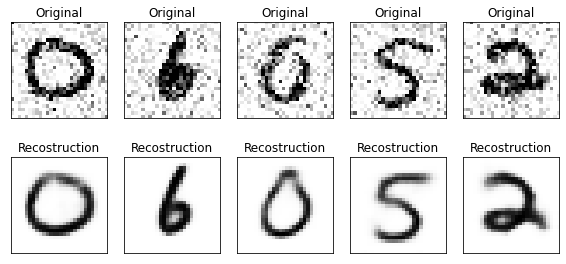

Test with 0.4 noise factor (0.1 original)



Denoising_Autoencoder
Test Loss(MSE):0.03806570917367935



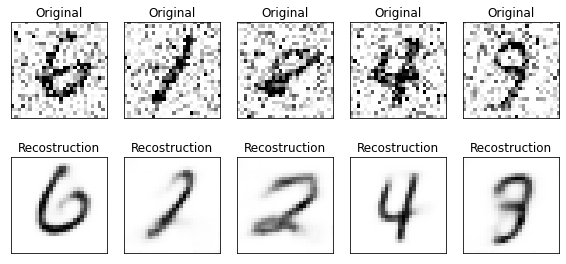

Test with 0.5 noise factor (0.1 original)



Denoising_Autoencoder
Test Loss(MSE):0.05247301235795021



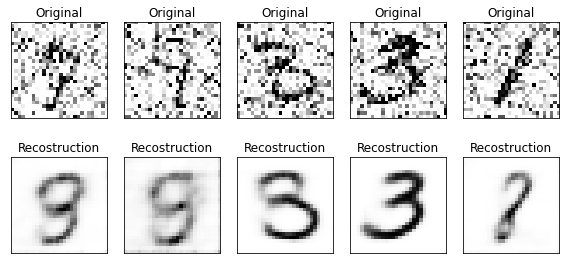

In [ ]:
original_noise_factor=0.1
noise_factor=original_noise_factor
for i in range(4):
  noise_factor=noise_factor+original_noise_factor
  print(f'Test with {noise_factor} noise factor ({original_noise_factor} original)')
  test_transform = transforms.Compose([
      transforms.ToTensor(),transforms.Lambda(lambda x : (torch.clip(x + noise_factor*torch.randn_like(x), 0, 1), x))
  ])
  test_dataset.transform = test_transform
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

  test_loss= [] 
  encoder.eval()
  decoder.eval()
  with torch.no_grad(): # Disable gradient tracking
    for (noise_image_batch,image_batch), _  in tqdm(test_dataloader):
      # Move tensor to the proper device
      noise_image_batch = noise_image_batch.to(device)
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder(noise_image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      test_loss.append(loss_batch)     
  test_loss = np.mean(test_loss)
  print(net_name)
  print(f"Test Loss(MSE):{test_loss}")
  print()


  encoder.eval()
  decoder.eval()
  fig, axs = plt.subplots(2, 5, figsize=(8,4))
  axs=axs.flatten()
  for i in range(len(axs)//2):
      shift=len(axs)//2
      noise_img = random.choice(test_dataset)[0][0].view([28,28])
      rec_img=decoder(encoder(noise_img.view([1,1,28,28]).to(device))).view([28,28])
      axs[i].imshow(np.array(noise_img), cmap='Greys')
      axs[i].set_title('Original')
      axs[i].set_xticks([])
      axs[i].set_yticks([])
      axs[i+shift].imshow(rec_img.cpu().detach().numpy(), cmap='Greys')
      axs[i+shift].set_title('Recostruction')
      axs[i+shift].set_xticks([])
      axs[i+shift].set_yticks([])
  plt.tight_layout()
  plt.show()

##Test on samples with different noise ("Salt and Pepper")

Test with 0.1 Salt and Pepper probability



Denoising_Autoencoder
Test Loss(MSE):0.021526813507080078



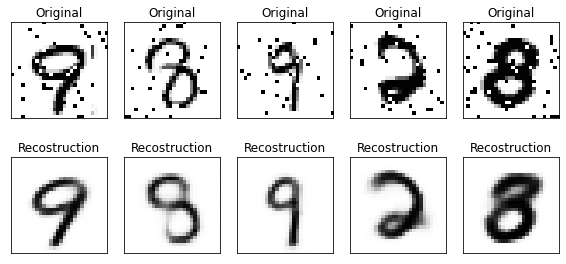

Test with 0.2 Salt and Pepper probability



Denoising_Autoencoder
Test Loss(MSE):0.028972988948225975



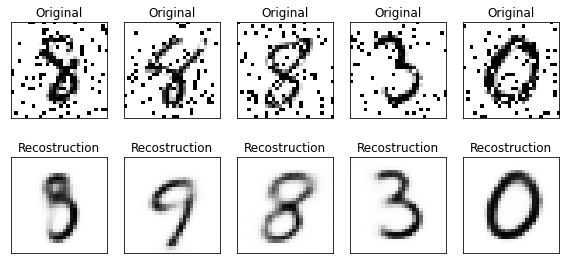

Test with 0.30000000000000004 Salt and Pepper probability



Denoising_Autoencoder
Test Loss(MSE):0.04216303676366806



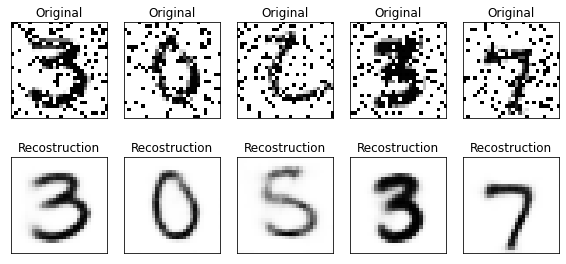

Test with 0.4 Salt and Pepper probability



Denoising_Autoencoder
Test Loss(MSE):0.05832802876830101



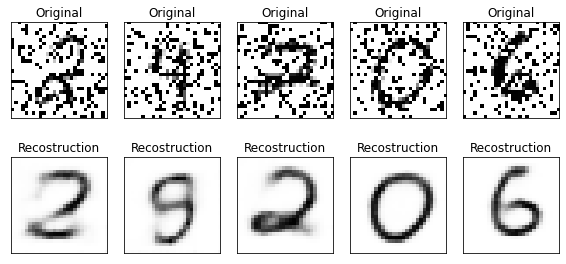

In [ ]:
def salt_and_pepper(x, salt_pepper_p=0.1):
  return torch.Tensor(np.random.choice([-1,0,1],size=x.size(),p=[0.5*salt_pepper_p,1-salt_pepper_p,0.5*salt_pepper_p]))

original_salt_pepper_p=0.1
salt_pepper_p=0
for i in range(4):
  salt_pepper_p=salt_pepper_p+original_salt_pepper_p
  print(f'Test with {salt_pepper_p} Salt and Pepper probability')
  test_transform = transforms.Compose([
      transforms.ToTensor(),transforms.Lambda(lambda x : (torch.clip(x + salt_and_pepper(x,salt_pepper_p=salt_pepper_p), 0, 1), x))
  ])
  test_dataset.transform = test_transform
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

  test_loss= [] 
  encoder.eval()
  decoder.eval()
  with torch.no_grad(): # Disable gradient tracking
    for (noise_image_batch,image_batch), _  in tqdm(test_dataloader):
      # Move tensor to the proper device
      noise_image_batch = noise_image_batch.to(device)
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder(noise_image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      test_loss.append(loss_batch)     
  test_loss = np.mean(test_loss)
  print(net_name)
  print(f"Test Loss(MSE):{test_loss}")
  print()


  encoder.eval()
  decoder.eval()
  fig, axs = plt.subplots(2, 5, figsize=(8,4))
  axs=axs.flatten()
  for i in range(len(axs)//2):
      shift=len(axs)//2
      noise_img = random.choice(test_dataset)[0][0].view([28,28])
      rec_img=decoder(encoder(noise_img.view([1,1,28,28]).to(device))).view([28,28])
      axs[i].imshow(np.array(noise_img), cmap='Greys')
      axs[i].set_title('Original')
      axs[i].set_xticks([])
      axs[i].set_yticks([])
      axs[i+shift].imshow(rec_img.cpu().detach().numpy(), cmap='Greys')
      axs[i+shift].set_title('Recostruction')
      axs[i+shift].set_xticks([])
      axs[i+shift].set_yticks([])
  plt.tight_layout()
  plt.show()

#Variational Autoencoder

In [ ]:
#set random seed
torch.manual_seed(0)
np.random.seed(0)

##Variational Encoder (Decoder is same as previous)

In [ ]:
class Var_Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_channels=32, n_fcl=200):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, num_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(num_channels, num_channels, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(num_channels, num_channels, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * num_channels, n_fcl),
            nn.ReLU(True),
        )

        #End section
        self.mu_layer = nn.Linear(n_fcl, encoded_space_dim)
        self.logvar_layer = nn.Linear(n_fcl, encoded_space_dim)
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # Apply linear layers
        x = self.encoder_lin(x)
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        #Sample from distribution if training
        if self.training:
          #sample gaussian with 0 mean and 1 std
          normal = torch.normal(torch.zeros(mu.size()), torch.ones(logvar.size())).to(device)         
          # torch.mul(a,b) => elementwise multiplication
          z = torch.add(torch.mul(normal, torch.exp(torch.mul(logvar,0.5))), mu)
          return z, mu, logvar        
        else:
          z = mu
          return z, mu, logvar

##Data

In [ ]:
dataset = torchvision.datasets.MNIST('mnist_dataset', train=True, download=True)
train_dataset = dataset
test_dataset  = torchvision.datasets.MNIST('mnist_dataset', train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

batch_size=50
train_dataset,val_dataset=torch.utils.data.random_split(dataset, [50000,10000])
train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

##Training

In [ ]:
path='best_model'
train_params=pd.read_csv(os.path.join(path,'train_params.csv'))

#Parameters
loss_fn = nn.MSELoss(reduction='sum')
def KL_div_loss(mu,log_var):return -0.5 * torch.sum(1 + logvar - torch.exp(logvar) - torch.pow(mu, 2))
num_epochs_max = 100
opt=train_params['optimizer'][0]
lr=train_params['lr'][0]
weight_decay=train_params['weight_decay'][0]
n_fcl = train_params["n_fcl"][0]
encoded_space_dim = train_params["encoded_space_dim"][0]

log_dataset_var={}

### Initialize the two networks
encoder = Var_Encoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
decoder = Decoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
params_to_optimize = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]
# Define the optimizer
optimizers={'SGDM':optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay, momentum=0.9),
            'Adam':optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay),
            'Adagrad':optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)}
optimizer = optimizers[opt] 

net_name=f'Variational_Autoencoder'

path=net_name
os.makedirs(path,exist_ok=True)

# Load the network parameters and data
time_training=0
try:
  time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
  encoder_state_dict=torch.load(os.path.join(path,'encoder_params.torch'),map_location=torch.device(dev))
  decoder_state_dict=torch.load(os.path.join(path,'decoder_params.torch'),map_location=torch.device(dev))
  encoder.load_state_dict(encoder_state_dict)
  decoder.load_state_dict(decoder_state_dict)
  try:
    log_dataset_var[net_name]
  except:
    log_dataset_var[net_name]=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_var[net_name]['train_loss']=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_var[net_name]['valid_loss']=pd.read_csv(os.path.join(path,'net_valid_loss.csv'))
  train=False
except:
  train=True

print('----------------------------------')
print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
print('----------------------------------')

### TRAINING LOOP
train_loss_log = []
val_loss_log = []
time_start = time.time()

if train:
  for epoch_num in range(num_epochs_max):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    encoder.train()
    decoder.train()
    for image_batch, _ in tqdm(train_dataloader):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data, mu, logvar = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      KL_loss = KL_div_loss(mu, logvar) 
      loss = loss_fn(decoded_data, image_batch) + KL_loss
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    ### VALIDATION
    val_loss= []
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      for image_batch, _ in tqdm(val_dataloader):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data, mu, logvar = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        KL_loss = KL_div_loss(mu, logvar) 
        loss = loss_fn(decoded_data, image_batch) + KL_loss

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average losses
    train_loss = np.mean(train_loss)      
    val_loss = np.mean(val_loss)
    print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
    print(f"\tAVERAGE VAL LOSS: {val_loss}")
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    #Early Stopping
    min_epochs=30
    window=10
    if epoch_num+1>=min_epochs and epoch_num+1>=window:
      print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
      if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
        print('Early Stopping')
        break

  time_end = time.time()
  time_training=time_end-time_start

  #Save data
  pd.DataFrame(train_loss_log,columns=['train_loss']).to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
  pd.DataFrame(val_loss_log,columns=['valid_loss']).to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
  try:
    log_dataset_var[net_name]
  except:
    log_dataset_var[net_name]=pd.DataFrame()
  log_dataset_var[net_name]['train_loss']=train_loss_log
  log_dataset_var[net_name]['valid_loss']=val_loss_log
  encoder_state_dict = encoder.state_dict()
  decoder_state_dict = decoder.state_dict()
  torch.save(encoder_state_dict, os.path.join(path,'encoder_params.torch'))
  torch.save(decoder_state_dict, os.path.join(path,'decoder_params.torch'))
  pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)

----------------------------------
Variational_Autoencoder -- training time: 7.0 min 11.05 sec
----------------------------------


##Error history

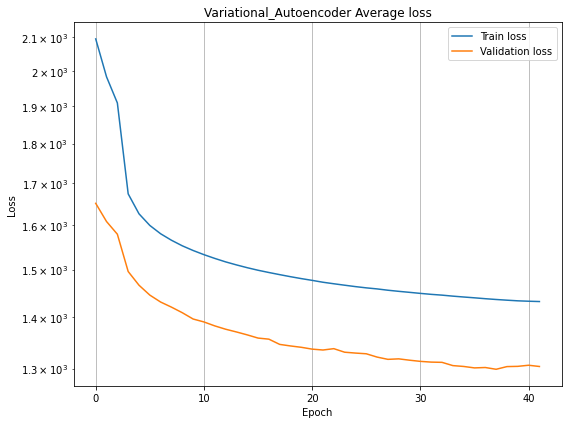

In [ ]:
smoothing_window=5       
smoothed_train_loss=log_dataset_var[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
smoothed_valid_loss=log_dataset_var[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
plt.figure(figsize=(8,6))
plt.title(net_name+' Average loss')
plt.semilogy(smoothed_train_loss, label='Train loss')
plt.semilogy(smoothed_valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

##Test performances

In [ ]:
loss_fn=nn.MSELoss()
test_loss= [] 
encoder.eval()
decoder.eval()
with torch.no_grad(): # Disable gradient tracking
  for image_batch, _  in tqdm(test_dataloader):
    # Move tensor to the proper device
    image_batch = image_batch.to(device)
    # Encode data
    encoded_data, mu, logvar = encoder(image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss 
    loss = loss_fn(decoded_data, image_batch)

    # Save val loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    test_loss.append(loss_batch)     
test_loss = np.mean(test_loss)
print(net_name)
print(f"Test Loss(MSE):{test_loss}")
print()


Variational_Autoencoder
Test Loss(MSE):0.020537663251161575



##Reconstructed samples

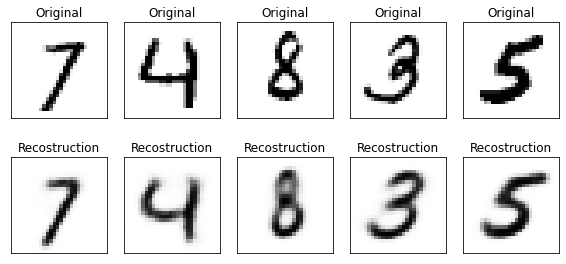

In [ ]:
encoder.eval()
decoder.eval()
fig, axs = plt.subplots(2, 5, figsize=(8,4))
axs=axs.flatten()
for i in range(len(axs)//2):
    shift=len(axs)//2
    img = random.choice(test_dataset)[0].view([28,28])
    rec_img=decoder(encoder(img.view([1,1,28,28]).to(device))[0]).view([28,28])
    axs[i].imshow(np.array(img), cmap='Greys')
    axs[i].set_title('Original')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+shift].imshow(rec_img.cpu().detach().numpy(), cmap='Greys')
    axs[i+shift].set_title('Recostruction')
    axs[i+shift].set_xticks([])
    axs[i+shift].set_yticks([])
plt.tight_layout()
plt.show()

##Explore latent space and generate samples

### Encoded Space

In [ ]:
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        encoded_img, _, _  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    labels.append(label)
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
display(encoded_samples)

Enc. Variable 0  Enc. Variable 1  ...  Enc. Variable 4  Enc. Variable 5
0            0.414673         1.263402  ...         1.366098         0.344265
1            0.871043        -1.334599  ...         1.977828        -0.643903
2           -0.350705        -0.325047  ...         1.120666         0.308716
3           -0.191834        -0.026877  ...        -1.279814        -0.909864
4           -0.659342         0.272406  ...        -0.034657        -0.870341
...               ...              ...  ...              ...              ...
9995         1.733794         0.532910  ...         0.058000        -1.946159
9996         0.670599        -1.486491  ...         0.927429         0.457419
9997        -0.220029         0.709183  ...        -1.341972        -1.145106
9998        -1.572712         1.342263  ...        -0.764958         1.666597
9999        -2.177060        -1.133168  ...        -1.154595        -0.726434

[10000 rows x 6 columns]

###PCA

In [ ]:
from sklearn.decomposition import PCA
n_components=2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples)
columns = [f'pca{i}' for i in range(n_components)]
encoded_samples_pca = pd.DataFrame(pca.transform(encoded_samples), columns=['pca1', 'pca2'])
display(encoded_samples_pca)

pca1      pca2
0    -0.286842  0.141778
1    -1.813680  0.853811
2    -0.952642 -0.094687
3     1.338723  0.457884
4     0.698779  1.172789
...        ...       ...
9995  0.341989  1.057125
9996 -1.436123 -0.222201
9997  1.383276  0.373669
9998  1.566777 -1.714354
9999  1.309199  0.780215

[10000 rows x 2 columns]

In [ ]:
encoded_samples_pca['label']=labels
import plotly.express as px
px.scatter(encoded_samples_pca, x='pca1', y='pca2', color=encoded_samples_pca.label.astype(str), opacity=0.7)

###t-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0)
encoded_samples_tsne = tsne.fit_transform(encoded_samples)

encoded_samples_tsne=pd.DataFrame(encoded_samples_tsne, columns=['tsne1', 'tsne2'])
display(encoded_samples_tsne)

tsne1      tsne2
0     -5.657279 -79.092522
1     -3.356241   4.245175
2    -49.434166  30.574242
3     31.154692  28.018183
4    -58.127777 -11.545819
...         ...        ...
9995   1.595959  -4.222119
9996  70.232216  13.205904
9997 -41.424812   6.476745
9998  47.653419 -55.824863
9999   1.221319  51.669247

[10000 rows x 2 columns]

In [ ]:
encoded_samples_tsne['label']=labels
import plotly.express as px
px.scatter(encoded_samples_tsne, x='tsne1', y='tsne2', color=encoded_samples_pca.label.astype(str), opacity=0.7)

### Sample from encoded space with sliding values and pca reconstruction

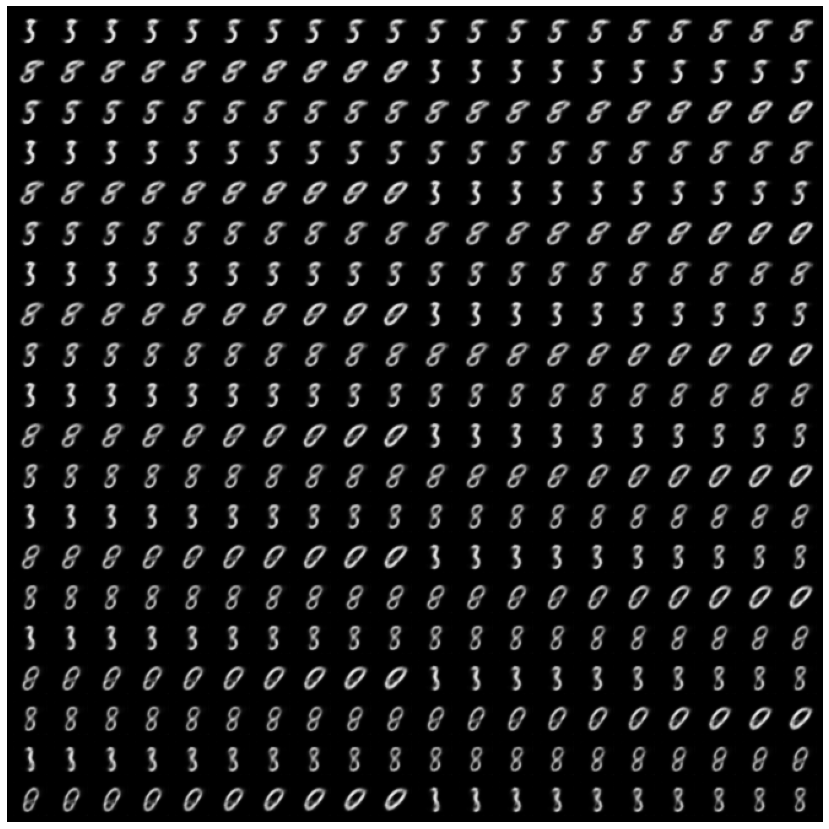

In [ ]:
with torch.no_grad():
  # Create empty (x, y) grid
  latent_x = np.linspace(-2, 2, 30)
  latent_y = np.linspace(-2, 2, 30)
  latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
  # Fill up the grid
  for i, lx in enumerate(latent_x):
    for j, ly in enumerate(latent_y):
      latents[j, i, 0] = lx
      latents[j, i, 1] = ly
  # Flatten the grid
  latents = latents.view(-1, 2)
  #Reproject data with PCA
  latents = torch.Tensor(pca.inverse_transform(latents))

  # Find their representation
  latents = latents.to(device)  
  reconstructions = decoder(latents).view(-1, 1, 28, 28)
  reconstructions = reconstructions.cpu()
  # Finally, plot
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructions.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0))) 
  plt.axis('off')

##Latent space dimension 2

###Training

In [ ]:
path='best_model'
train_params=pd.read_csv(os.path.join(path,'train_params.csv'))

#Parameters
loss_fn = nn.MSELoss(reduction='sum')
def KL_div_loss(mu,log_var):return -0.5 * torch.sum(1 + logvar - torch.exp(logvar) - torch.pow(mu, 2))
num_epochs_max = 100
opt=train_params['optimizer'][0]
lr=train_params['lr'][0]
weight_decay=train_params['weight_decay'][0]
n_fcl = train_params["n_fcl"][0]
encoded_space_dim = 2

### Initialize the two networks
encoder = Var_Encoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
decoder = Decoder(encoded_space_dim=encoded_space_dim,n_fcl=n_fcl).to(device)
params_to_optimize = [{'params': encoder.parameters()},
                      {'params': decoder.parameters()}]
# Define the optimizer
optimizers={'SGDM':optim.SGD(params_to_optimize, lr=lr, weight_decay=weight_decay, momentum=0.9),
            'Adam':optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay),
            'Adagrad':optim.Adagrad(params_to_optimize, lr=lr, weight_decay=weight_decay)}
optimizer = optimizers[opt] 

net_name=f'Variational_Autoencoder_2EncSpaceDim'

path=net_name
os.makedirs(path,exist_ok=True)

# Load the network parameters and data
time_training=0
try:
  time_training=pd.read_csv(os.path.join(path,'time_training.csv')).iloc[0,0]
  encoder_state_dict=torch.load(os.path.join(path,'encoder_params.torch'),map_location=torch.device(dev))
  decoder_state_dict=torch.load(os.path.join(path,'decoder_params.torch'),map_location=torch.device(dev))
  encoder.load_state_dict(encoder_state_dict)
  decoder.load_state_dict(decoder_state_dict)
  try:
    log_dataset_var[net_name]
  except:
    log_dataset_var[net_name]=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_var[net_name]['train_loss']=pd.read_csv(os.path.join(path,'net_train_loss.csv'))
  log_dataset_var[net_name]['valid_loss']=pd.read_csv(os.path.join(path,'net_valid_loss.csv'))
  train=False
except:
  train=True

print('----------------------------------')
print(net_name,f'-- training time: {time_training//60} min {round(time_training%60,2)} sec')
print('----------------------------------')

### TRAINING LOOP
train_loss_log = []
val_loss_log = []
time_start = time.time()

if train:
  for epoch_num in range(num_epochs_max):
    print(f'EPOCH {epoch_num}')

    ### TRAIN
    train_loss= []
    encoder.train()
    decoder.train()
    for image_batch, _ in tqdm(train_dataloader):
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data, mu, logvar = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)
      # Evaluate loss
      KL_loss = KL_div_loss(mu, logvar) 
      loss = loss_fn(decoded_data, image_batch) + KL_loss
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    ### VALIDATION
    val_loss= []
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Disable gradient tracking
      for image_batch, _ in tqdm(val_dataloader):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data, mu, logvar = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        KL_loss = KL_div_loss(mu, logvar) 
        loss = loss_fn(decoded_data, image_batch) + KL_loss

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

    # Save average losses
    train_loss = np.mean(train_loss)      
    val_loss = np.mean(val_loss)
    print(f"\tAVERAGE TRAIN LOSS: {train_loss}")      
    print(f"\tAVERAGE VAL LOSS: {val_loss}")
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    #Early Stopping
    min_epochs=30
    window=10
    if epoch_num+1>=min_epochs and epoch_num+1>=window:
      print('Last Mean:{} , Previous Mean:{}'.format(np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1]),np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]))) 
      if np.mean(val_loss_log[epoch_num+1-window//2:epoch_num+1])>np.mean(val_loss_log[epoch_num+1-window:epoch_num+1-window//2]):
        print('Early Stopping')
        break

  time_end = time.time()
  time_training=time_end-time_start

  #Save data
  pd.DataFrame(train_loss_log,columns=['train_loss']).to_csv(os.path.join(path,'net_train_loss.csv'),index=False)
  pd.DataFrame(val_loss_log,columns=['valid_loss']).to_csv(os.path.join(path,'net_valid_loss.csv'),index=False)
  try:
    log_dataset_var[net_name]
  except:
    log_dataset_var[net_name]=pd.DataFrame()
  log_dataset_var[net_name]['train_loss']=train_loss_log
  log_dataset_var[net_name]['valid_loss']=val_loss_log
  encoder_state_dict = encoder.state_dict()
  decoder_state_dict = decoder.state_dict()
  torch.save(encoder_state_dict, os.path.join(path,'encoder_params.torch'))
  torch.save(decoder_state_dict, os.path.join(path,'decoder_params.torch'))
  pd.DataFrame([time_training],columns=['Training Time']).to_csv(os.path.join(path,'time_training.csv'),index=False)

----------------------------------
Variational_Autoencoder_2EncSpaceDim -- training time: 11.0 min 57.98 sec
----------------------------------


###Error history

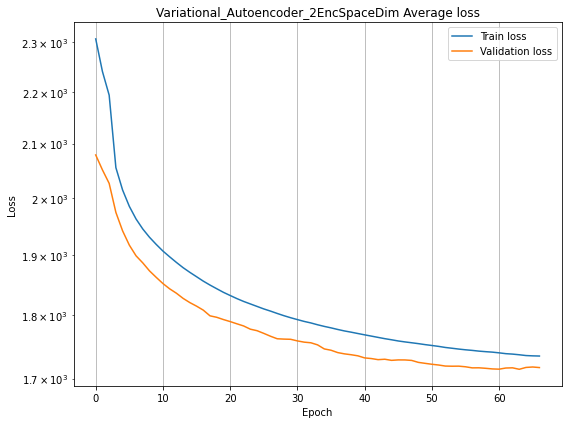

In [ ]:
smoothing_window=5       
smoothed_train_loss=log_dataset_var[net_name]['train_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
smoothed_valid_loss=log_dataset_var[net_name]['valid_loss'].rolling(smoothing_window, min_periods=1,center=True).mean()
plt.figure(figsize=(8,6))
plt.title(net_name+' Average loss')
plt.semilogy(smoothed_train_loss, label='Train loss')
plt.semilogy(smoothed_valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

###Test performances

In [ ]:
loss_fn=nn.MSELoss()
test_loss= [] 
encoder.eval()
decoder.eval()
with torch.no_grad(): # Disable gradient tracking
  for image_batch, _  in tqdm(test_dataloader):
    # Move tensor to the proper device
    image_batch = image_batch.to(device)
    # Encode data
    encoded_data, mu, logvar = encoder(image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss 
    loss = loss_fn(decoded_data, image_batch)

    # Save val loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    test_loss.append(loss_batch)     
test_loss = np.mean(test_loss)
print(net_name)
print(f"Test Loss(MSE):{test_loss}")
print()


Variational_Autoencoder_2EncSpaceDim
Test Loss(MSE):0.03731875494122505



### Encoded Space

In [ ]:
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        encoded_img, _, _  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    labels.append(label)
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
display(encoded_samples)

Enc. Variable 0  Enc. Variable 1
0           -0.869933         1.076206
1            0.812755        -0.099542
2            0.636004         1.971499
3            0.383357        -1.207217
4           -1.728285         0.259379
...               ...              ...
9995         1.572682         0.033433
9996        -0.044845        -0.557880
9997        -0.225690         0.602002
9998         0.819203         0.465526
9999         0.662432        -0.869712

[10000 rows x 2 columns]

In [ ]:
encoded_samples['label']=labels
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

### Sample from encoded space with sliding values

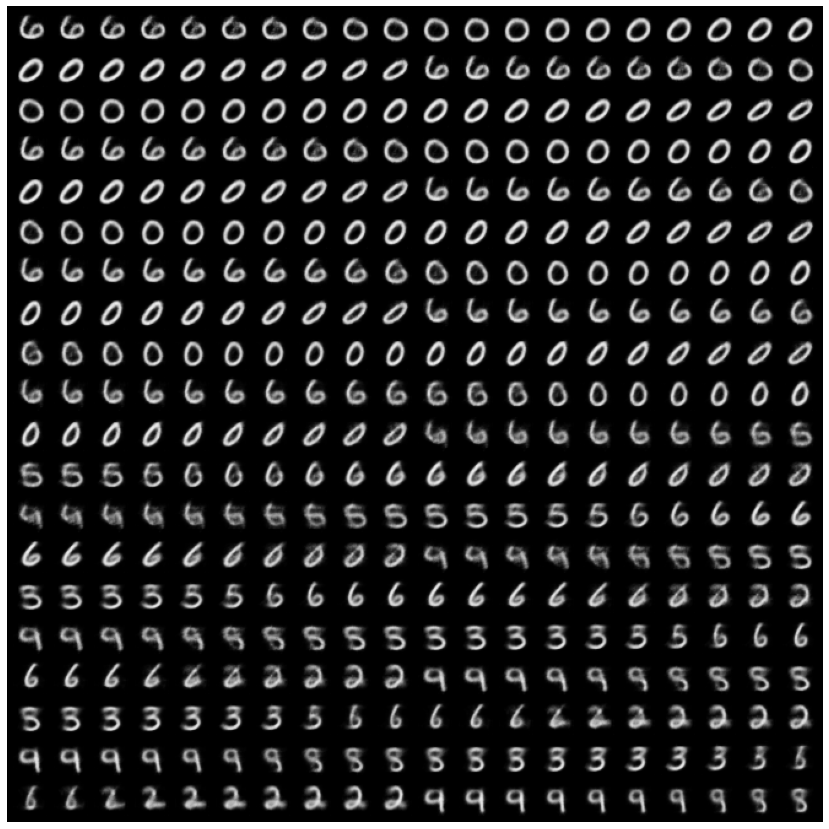

In [ ]:
with torch.no_grad():
  # Create empty (x, y) grid
  latent_x = np.linspace(-2, 2, 30)
  latent_y = np.linspace(-2, 2, 30)
  latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
  # Fill up the grid
  for i, lx in enumerate(latent_x):
    for j, ly in enumerate(latent_y):
      latents[j, i, 0] = lx
      latents[j, i, 1] = ly
  # Flatten the grid
  latents = latents.view(-1, 2)

  # Find their representation
  latents = latents.to(device)  
  reconstructions = decoder(latents).view(-1, 1, 28, 28)
  reconstructions = reconstructions.cpu()
  # Finally, plot
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructions.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0))) 
  plt.axis('off')